## Bibliotecas Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regex as re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from operator import itemgetter

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
# stopwords e simbolos a retirar
stop_words_portugues = set(['co','de','a','o','que','e','é','do','da','em','um','para','com','não','uma','os','no','se','na','por','mais','as','dos','como','mas','ao','ele','das','à','seu','sua','ou','quando','muito','nos','já','eu','também','só','pelo','pela','até','isso','ela','entre','depois','sem','mesmo','aos','seus','quem','nas','me','esse','eles','você','essa','num','nem','suas','meu','às','minha','numa','pelos','elas','qual','nós','lhe','deles','essas','esses','pelas','este','dele','tu','te','vocês','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso','nossa','nossos','nossas','dela','delas','esta','estes','estas','aquele','aquela','aqueles','aquelas','isto','aquilo','estou','está','estamos','estão','estive','esteve','estivemos','estiveram','estava','estávamos','estavam','estivera','estivéramos','esteja','estejamos','estejam','estivesse','estivéssemos','estivessem','estiver','estivermos','estiverem','hei','há','havemos','hão','houve','houvemos','houveram','houvera','houvéramos','haja','hajamos','hajam','houvesse','houvéssemos','houvessem','houver','houvermos','houverem','houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou','somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja','sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será','seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos','tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham','tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos','terão','teria','teríamos','teriam'])
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '.', '|'])

In [3]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopico #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [5]:
def tweet_tokenizer(text):
    tweet = text.lower()
    tweet_token = [w for w in re.split('\W+', tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
    tweet_token = [w for w in tweet_token if not (w.startswith('@') | w.startswith('#'))]
    tweet_token = [w for w in tweet_token if w != 'rt']
        
    return emoji(" ".join(tweet_token))

# Carregando os dados 

In [6]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
    cols = ['nome'] + [col for col in df_politicos if col != 'nome']
    df_politicos = df_politicos[cols]

In [7]:
df_politicos.head(10)

,nome,created_at,text,id
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296
5,Amoedo,2021-04-19T12:19:42Z,A CPI da Pandemia no Senado deve investigar o ...,1384119514418216969
6,Amoedo,2021-04-18T19:21:07Z,Leia a coluna completa em https://t.co/rvNDUpnqgA,1383863178853969921
7,Amoedo,2021-04-18T19:21:06Z,"""Membros do Executivo e do Legislativo não ace...",1383863176891015168
8,Amoedo,2021-04-18T15:42:35Z,Informações de @RevistaEpoca,1383808183223734272
9,Amoedo,2021-04-18T15:42:25Z,O governo federal gastará R$500 mil em uma cam...,1383808141897342986


In [8]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31633 entries, 0 to 1294
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nome        31633 non-null  object
 1   created_at  31633 non-null  object
 2   text        31633 non-null  object
 3   id          31633 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


## Dataframe de frequências e teste de stopwords

In [9]:
dados = set()
for politico in nome_politicos:
    # separando as palavras
    palavras = "".join(df_politicos[df_politicos['nome'] == politico]['text']).lower()
    palavras = re.split('\W+', palavras)
    # retirando stopwords, web links, simbolos e outros
    palavras = [w for w in palavras if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    palavras = [w for w in palavras if re.match(r'http*', w) == None]
    palavras = [w for w in palavras if not (w.startswith('@') | w.startswith('#'))]
    palavras = [w for w in palavras if w != 'rt']
    # gerando a frequência das palavras
    c = Counter(palavras)
    # retirando palavras com frequencia menor do que 10 e adicionando o nome do candidato
    d = {(politico,x,y) for x,y in zip(c,c.values()) if y > 10}
    print(politico, len(d))
    for x in d:
        dados.add(x)
        
# montando o dataframe
df = pd.DataFrame(dados, columns=['candidato', 'texto', 'frequencia'])

Amoedo 1156
Bolsonaro 849
Boulos 832
Ciro 679
Doria 897
Huck 568
Leite 1242
Lula 877
Mandetta 305
Marina 1070
Moro 384


In [10]:
df[df['candidato'] == 'Moro'].head(50)

,candidato,texto,frequencia
51,Moro,agora,24
57,Moro,parabéns,44
148,Moro,brasília,12
258,Moro,prisão,35
265,Moro,outras,20
271,Moro,verdade,15
296,Moro,passado,11
307,Moro,favor,14
331,Moro,resposta,11
354,Moro,equipe,13


In [11]:
df.sort_values('frequencia', ascending=False)[:50]

,candidato,texto,frequencia
2540,Lula,lula,890
1256,Doria,sp,863
6107,Leite,rs,744
1629,Marina,governo,716
5957,Doria,paulo,579
239,Ciro,bolsonaro,554
6889,Boulos,pra,552
3082,Marina,presidente,551
5123,Leite,vamosriogrande,537
8603,Amoedo,brasil,536


## WordCloud de todos

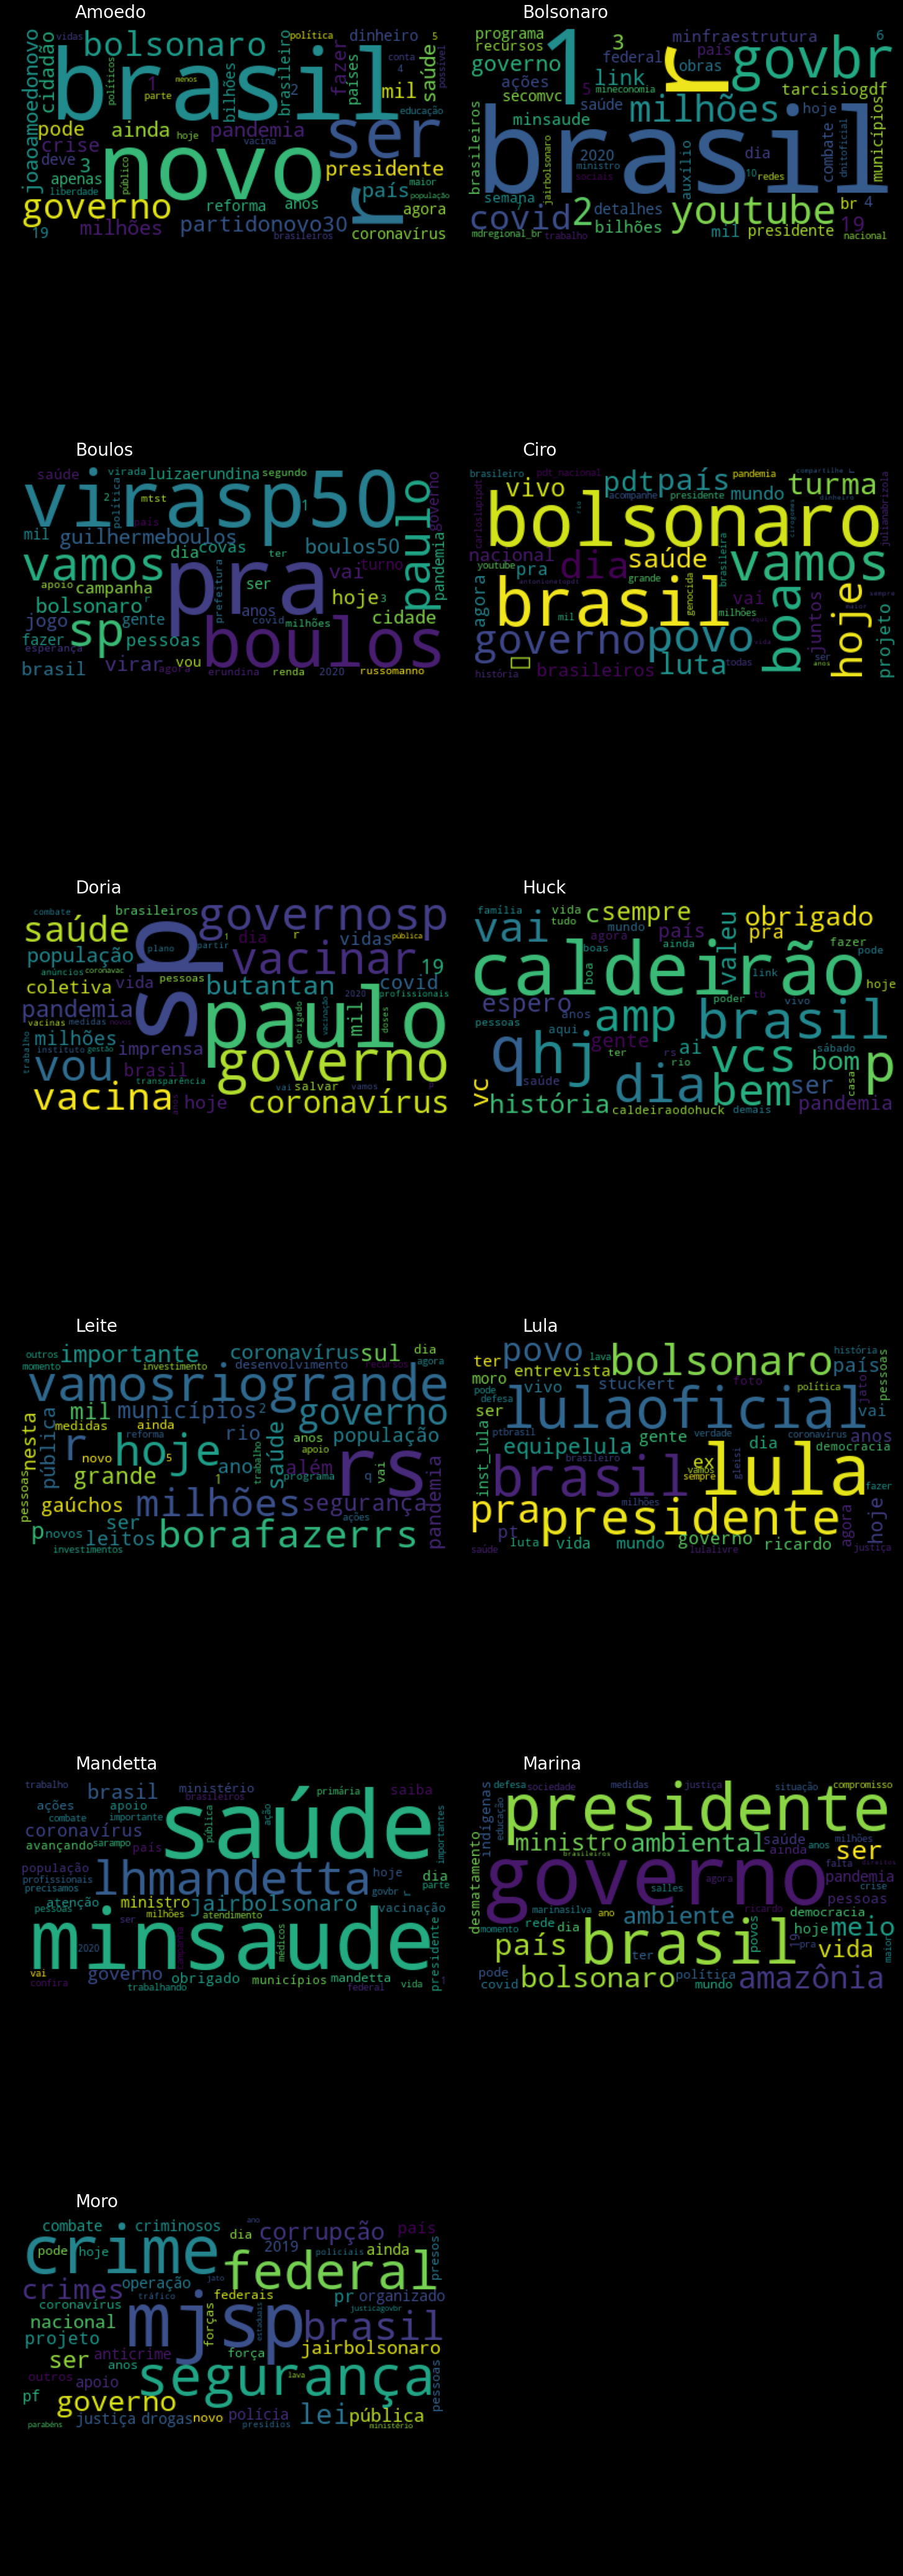

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='k')
xc = 0
yc = 0
for politico in nome_politicos:
    new_df = df[df['candidato'] == politico][['texto', 'frequencia']].sort_values('frequencia', ascending=False)[: 50]
    new_df = new_df.rename(columns={"texto": "words", "frequencia": "counts"})
    wordcloud = WordCloud().generate_from_frequencies(dict([tuple(x) for x in new_df.values]))
    ax[xc][yc].imshow(wordcloud)
    ax[xc][yc].text(50, -10, politico, fontsize=28, color='white')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.axis('off')
plt.tight_layout(pad=0) 
plt.show()

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

In [13]:
df_politicos['tweet_token'] = 'NaN'
df_politicos['tweet_token'] = df_politicos['text'].apply(tweet_tokenizer)
df_politicos.head()

,nome,created_at,text,id,tweet_token
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735,mblivre presidente americano joe biden anuncia...
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259,fazer parte podemos deixar brasil continuar an...
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825,governo federal congresso ignoraram orçamento ...
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517,o_antagonista joaoamoedonovo sugeriu twitter t...
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296,informações oglobopolitica


In [14]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(list(df_politicos['tweet_token']))
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(tf)

n_top_words = 3
print("\nTópico no Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Tópico no Modelo LDA: 
**********************************************************************

Topico #0:brasil presidente lula

Topico #1:vacina vivo casa

Topico #2:sociais mulheres redes

Topico #3:amazônia lhmandetta vamosriogrande

Topico #4:lulaoficial acompanhe entrevista

Topico #5:governo saúde brasil

Topico #6:obrigado caldeirão virasp50

Topico #7:proteção jairbolsonaro govbr

Topico #8:pra governo ser

Topico #9:boa vacinar lá


## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos Politicos

In [15]:
tf_vectorizer = CountVectorizer()
for politico in nome_politicos:
    tf = tf_vectorizer.fit_transform((list(df_politicos[df_politicos['nome'] == politico]['tweet_token'])))
    lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)
    lda.fit(tf)

    n_top_words = 3
    print(f"\nTópico no Modelo LDA: {politico}")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    print("*"*70)
    print("*"*70)
    print("*"*70)


Tópico no Modelo LDA: Amoedo

Topico #0:conta informações 19

Topico #1:vacina anos pt

Topico #2:novo partidonovo30 presidente

Topico #3:joaoamoedonovo cuide live

Topico #4:comunicação oxigênio online

Topico #5:brasil bolsonaro saúde

Topico #6:informações casa médicos

Topico #7:fonte mundial banco

Topico #8:assista cirogomes bancos

Topico #9:brasil novo ser
**********************************************************************
**********************************************************************
**********************************************************************

Tópico no Modelo LDA: Bolsonaro

Topico #0:youtube link presidente

Topico #1:brasil govbr milhões

Topico #2:conexaopolitica equipe exército

Topico #3:rogeriosmarinho mdregional_br água

Topico #4:fab_oficial defesagovbr covid

Topico #5:prfbrasil justicagovbr boa

Topico #6:brazil posto diversas

Topico #7:fake news idosos

Topico #8:crianças arthurweint amapá

Topico #9:povo dia bom
***************************